## 3.2 Tensor Flow Project (TEXT): word2vec skip-gram algorithm

In [1]:
import time

import numpy as np
import tensorflow as tf

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

import re
from collections import Counter

import random

In [13]:
# Helper function for 3.2
def preprocess(text):
    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words


def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [3]:
dataset_folder_path = '../ClassSampleData/'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('../ClassSampleData/text8') as f:
    text = f.read()

### Preprocess data to create vocabary and convert word to int

In [4]:
words = preprocess(text)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

### Subsampling to reduce data noise: drop rate $ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $

In [5]:
threshold = 1e-5

word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}

p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

### Build train graph

In [7]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features
n_sampled = 100 # Number of negative labels to sample
valid_size = 5 # Random set of words to evaluate similarity on.
valid_window = 100

train_graph = tf.Graph()

with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

    # Embedding
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)
    
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    ## From Thushan Ganegedara's implementation

    # pick samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Train the model

In [9]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 1000 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 5000 == 0:
                # note that this is expensive
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 1000 Avg. Training loss: 55.5853 0.2052 sec/batch
Epoch 1/10 Iteration: 2000 Avg. Training loss: 52.0076 0.2063 sec/batch
Epoch 1/10 Iteration: 3000 Avg. Training loss: 48.4157 0.2045 sec/batch
Epoch 1/10 Iteration: 4000 Avg. Training loss: 47.2309 0.2038 sec/batch
Epoch 2/10 Iteration: 5000 Avg. Training loss: 46.0122 0.0760 sec/batch
Nearest to three: four, hailing, rowers, jasper, codon, rivera, population, ketos,
Nearest to this: gundam, permits, diamonds, objectivity, matter, kinds, duality, fahd,
Nearest to not: unhelpful, that, value, damn, jeopardy, manipulating, snowmobile, universitario,
Nearest to has: surprised, reclaimed, storyline, misunderstanding, raul, insecure, feathers, terrain,
Nearest to is: vapor, behold, mount, unlucky, superceded, weissmuller, phodopus, sms,
Nearest to they: delusional, rather, parenthesized, caring, vickers, profiled, vulnerabilities, portage,
Nearest to some: stimulated, and, cavalli, broadening, bureaucrats, destroy, alo

Nearest to that: not, omniscient, very, pursuance, corrupted, uninteresting, say, omnipotent,
Nearest to construction: kylix, goods, constructed, entrepreneurs, transportation, engraving, raions, lavishly,
Nearest to discovered: screwtape, paleocene, gulls, insensible, interstellar, probe, carinthia, bang,
Nearest to mean: sun, mennonites, iff, mu, romero, computed, unreleased, balmaceda,
Nearest to hold: for, sauna, doctrine, degrees, supermanica, pistons, harbors, met,
Nearest to award: awards, bafta, best, nominated, emmy, objectors, sportswriter, nominations,
Nearest to consists: branch, each, lower, volcanic, a, sfr, gallbladder, alkanes,
Nearest to animals: captivity, prey, hunt, species, lineage, espero, animal, breeding,
Nearest to nobel: physiology, prize, financier, biochemist, laureate, christof, albers, thysanoessa,
Epoch 6/10 Iteration: 26000 Avg. Training loss: 39.5020 0.2038 sec/batch
Epoch 6/10 Iteration: 27000 Avg. Training loss: 39.5751 0.2037 sec/batch
Epoch 7/10 Ite

### Save and restore trained model

In [10]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


### Visualize word vector cluster

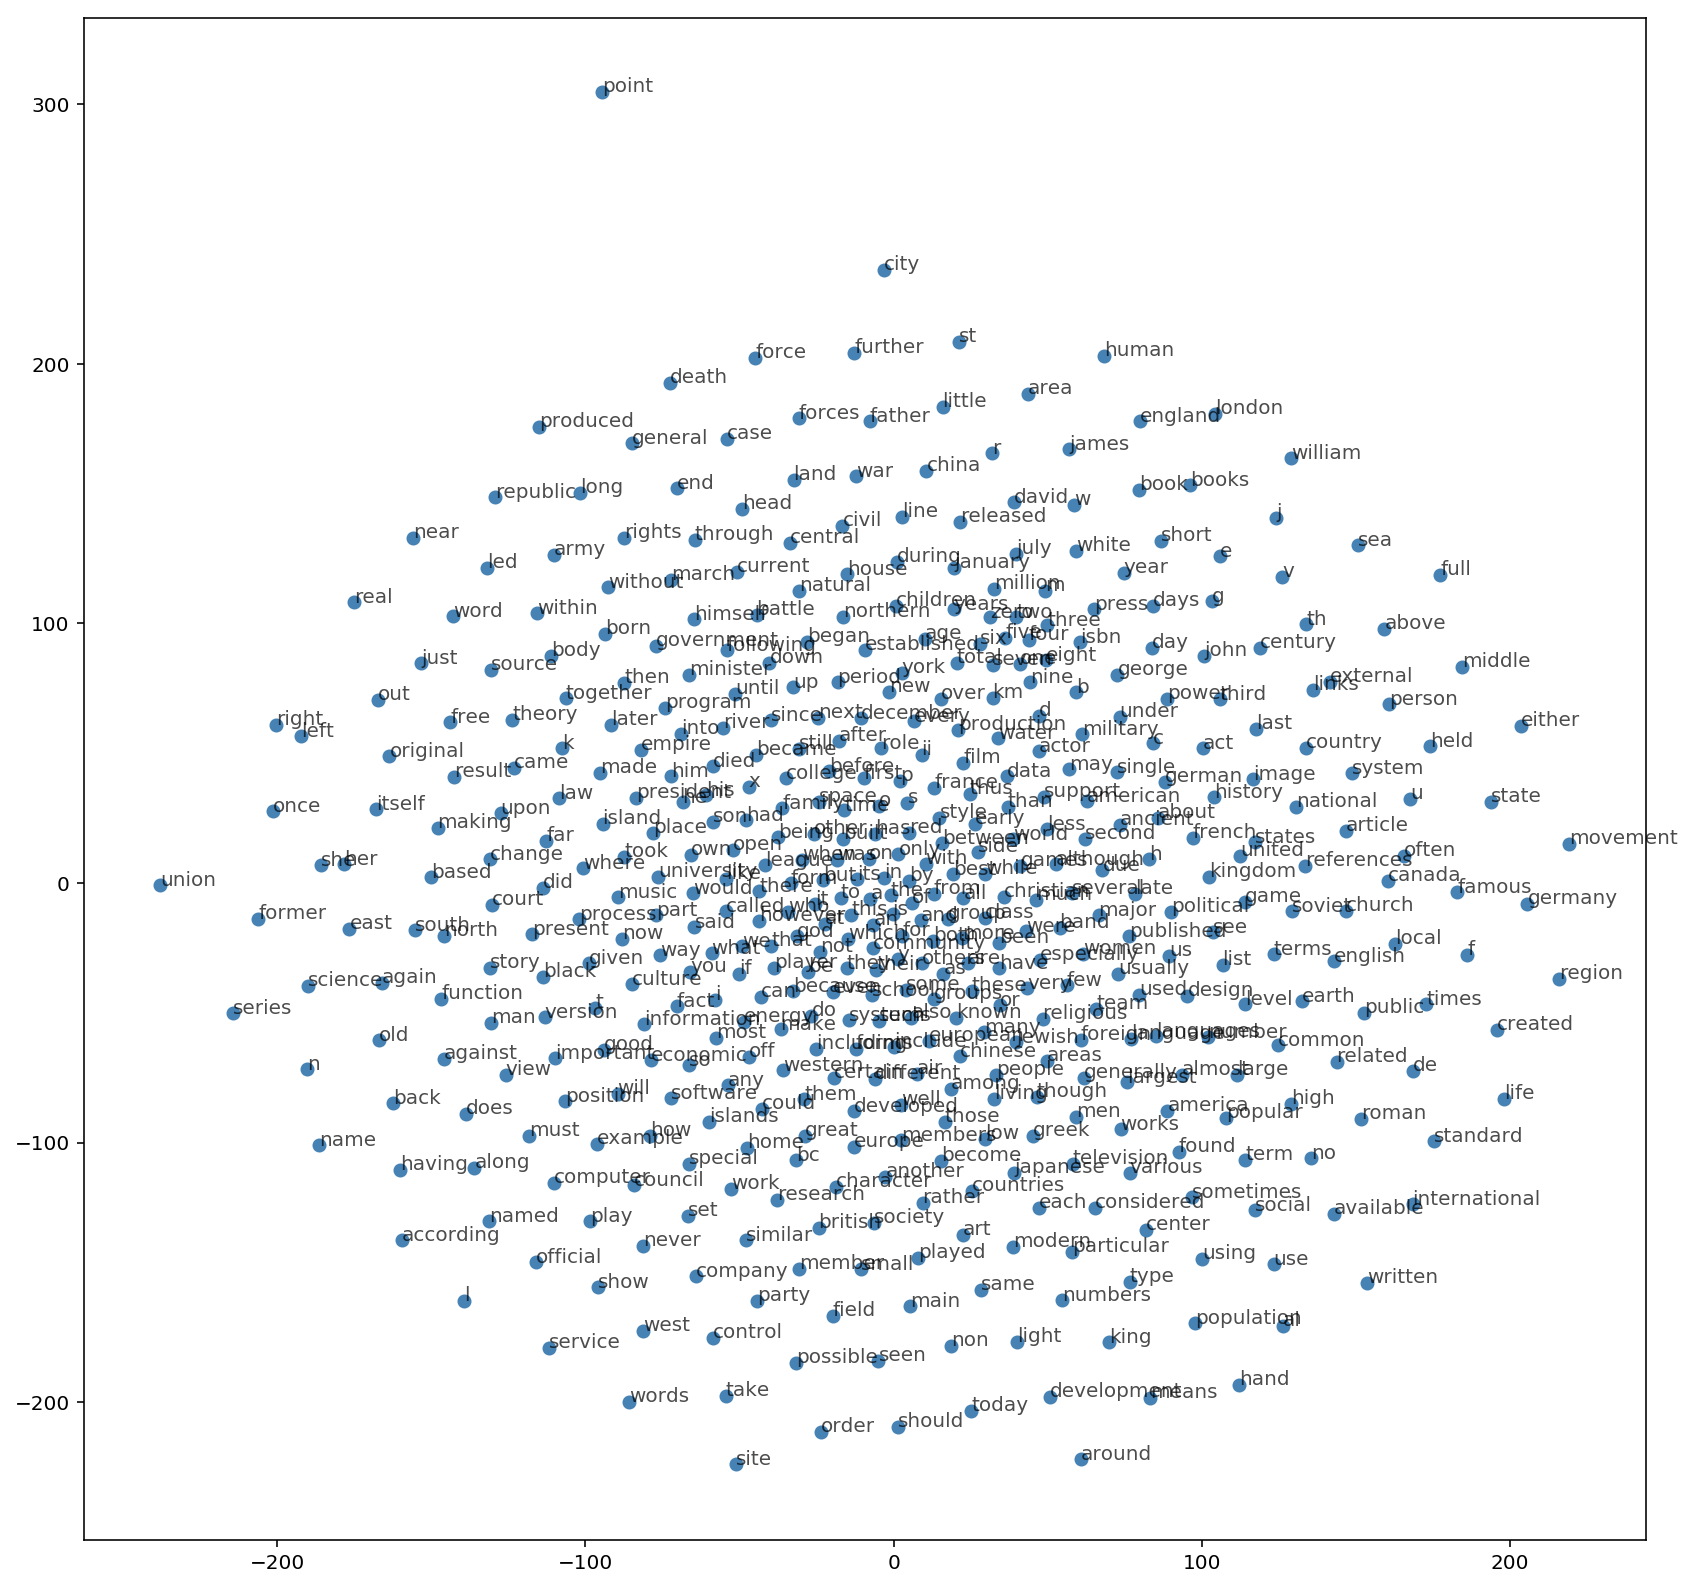

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)